In [186]:
import torch
import math
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import torch
import triton
import triton.language as tl

In [191]:
import torch
import triton
import triton.language as tl

# Precompute random projection matrix on the host
def precompute_random_projection(D, K_REDUCED):
    torch.manual_seed(42)  # For reproducibility
    return torch.randn(D, K_REDUCED, dtype=torch.float32, device="cuda")  # Precompute projection matrix

def precompute_projected_qk(Q, K, rand_proj):
    Q_proj = torch.matmul(Q, rand_proj)  # Precompute projected Q
    K_proj = torch.matmul(K, rand_proj)  # Precompute projected K
    return Q_proj, K_proj

@triton.jit
def optimized_fasta_kernel(
    Q_proj_ptr, K_proj_ptr, attn_ptr,
    B, H, N, K_REDUCED: tl.constexpr, BLOCK_SIZE: tl.constexpr,
    stride_qb, stride_qh, stride_q0, stride_q1,
    stride_kb, stride_kh, stride_k0, stride_k1,
    stride_attnb, stride_attnh, stride_attn0, stride_attn1
):
    pid = tl.program_id(0)
    n_blocks = tl.cdiv(N, BLOCK_SIZE)
    b_idx = pid // (H * n_blocks * n_blocks)
    head_idx = (pid // (n_blocks * n_blocks)) % H
    block_idx = pid % (n_blocks * n_blocks)
    row_block_idx = block_idx // n_blocks
    col_block_idx = block_idx % n_blocks

    row_start = row_block_idx * BLOCK_SIZE
    col_start = col_block_idx * BLOCK_SIZE

    offs_q = row_start + tl.arange(0, BLOCK_SIZE)
    offs_k = col_start + tl.arange(0, BLOCK_SIZE)

    acc = tl.zeros((BLOCK_SIZE, BLOCK_SIZE), dtype=tl.float32)

    q_proj_ptrs = Q_proj_ptr + b_idx * stride_qb + head_idx * stride_qh + offs_q[:, None] * stride_q0 + tl.arange(0, K_REDUCED)[None, :] * stride_q1
    k_proj_ptrs = K_proj_ptr + b_idx * stride_kb + head_idx * stride_kh + offs_k[:, None] * stride_k0 + tl.arange(0, K_REDUCED)[None, :] * stride_k1

    q_proj_block = tl.load(q_proj_ptrs)
    k_proj_block = tl.load(k_proj_ptrs)

    # Compute approximate attention
    acc += tl.dot(q_proj_block, tl.trans(k_proj_block))

    offs_attn_i = row_start + tl.arange(0, BLOCK_SIZE)
    offs_attn_j = col_start + tl.arange(0, BLOCK_SIZE)
    attn_ptrs = attn_ptr + b_idx * stride_attnb + head_idx * stride_attnh + offs_attn_i[:, None] * stride_attn0 + offs_attn_j[None, :] * stride_attn1
    mask = (offs_attn_i[:, None] < N) & (offs_attn_j[None, :] < N)
    tl.store(attn_ptrs, acc, mask=mask)

def fasta_attn(Q, K, block_size):
    B, H, N, D = Q.shape
    K_REDUCED = 16  # Fixed reduced dimensionality

    # Precompute random projection matrix
    rand_proj = precompute_random_projection(D, K_REDUCED)

    # Precompute projected Q and K
    Q_proj, K_proj = precompute_projected_qk(Q, K, rand_proj)

    Q_proj = Q_proj.contiguous()
    K_proj = K_proj.contiguous()

    attn = torch.empty((B, H, N, N), device=Q.device, dtype=Q.dtype)

    n_blocks = triton.cdiv(N, block_size)
    grid = (B * H * n_blocks * n_blocks,)

    optimized_fasta_kernel[grid](
        Q_proj, K_proj, attn,
        B, H, N, K_REDUCED, block_size,
        Q_proj.stride(0), Q_proj.stride(1), Q_proj.stride(2), Q_proj.stride(3),
        K_proj.stride(0), K_proj.stride(1), K_proj.stride(2), K_proj.stride(3),
        attn.stride(0), attn.stride(1), attn.stride(2), attn.stride(3)
    )

    return attn

def test_fasta_attention_benchmark(N, D, block_size, num_iterations):
    """
    Benchmark function for optimized FASTA attention implementation
    and standard self-attention. Includes batching for efficiency.
    """

    device = 'cuda'

    assert torch.cuda.is_available(), "CUDA is not available. Please run on a CUDA-enabled device."

    torch.manual_seed(0)
    Q = torch.randn(N, D, device=device, dtype=torch.float32)
    K = torch.randn(N, D, device=device, dtype=torch.float32)

    Q_fasta = Q.unsqueeze(0).unsqueeze(0)
    K_fasta = K.unsqueeze(0).unsqueeze(0)

    print("Computing standard self-attention for all iterations...")
    standard_times = []
    standard_outputs = []

    for idx in range(num_iterations):
        start_std = torch.cuda.Event(enable_timing=True)
        end_std = torch.cuda.Event(enable_timing=True)

        start_std.record()
        attn_ref = Q @ K.T
        end_std.record()

        torch.cuda.synchronize()
        elapsed_std = start_std.elapsed_time(end_std)
        standard_times.append(elapsed_std)
        if idx % 1000 == 0:
            standard_outputs.append(attn_ref.detach().cpu().numpy())

    print("Computing optimized FASTA attention for all iterations...")
    fasta_times = []
    fasta_outputs = []

    for idx in range(num_iterations):
        start_fasta = torch.cuda.Event(enable_timing=True)
        end_fasta = torch.cuda.Event(enable_timing=True)

        start_fasta.record()
        attn_fasta = fasta_attn(Q_fasta, K_fasta, block_size=block_size).squeeze(0).squeeze(0)
        end_fasta.record()

        torch.cuda.synchronize()
        elapsed_fasta = start_fasta.elapsed_time(end_fasta)
        fasta_times.append(elapsed_fasta)
        if idx % 1000 == 0:
            fasta_outputs.append(attn_fasta.detach().cpu().numpy())

    standard_times = torch.tensor(standard_times)
    fasta_times = torch.tensor(fasta_times)

    print("Benchmarking completed!")
    print("\nTiming Statistics:")
    print(f"Standard Self-Attention - Mean: {standard_times.mean():.4f} ms, Std: {standard_times.std():.4f} ms")
    print(f"FASTA Attention - Mean: {fasta_times.mean():.4f} ms, Std: {fasta_times.std():.4f} ms")
    print(f"Percentage Improvement: {100 * (1 - fasta_times.mean() / standard_times.mean()):.2f}%")

    print("\nError Metrics (Average over all iterations):")
    mae_list = []
    max_error_list = []
    relative_error_list = []

    for ref, fasta in zip(standard_outputs, fasta_outputs):
        abs_diff = torch.abs(torch.tensor(ref) - torch.tensor(fasta))
        mae_list.append(abs_diff.mean().item())
        max_error_list.append(abs_diff.max().item())
        relative_error_list.append((abs_diff / (torch.abs(torch.tensor(ref)) + 1e-6)).mean().item())

    print(f"Mean Absolute Error (MAE): {torch.tensor(mae_list).mean():.6f}")
    print(f"Maximum Absolute Error: {torch.tensor(max_error_list).mean():.6f}")
    print(f"Relative Error: {torch.tensor(relative_error_list).mean():.6f}")
    return standard_outputs, fasta_outputs


In [192]:
N = 2048
D = 64
block_size = 64
k_small = 16
num_iter = 10000

In [193]:
standard_outputs, fasta_outputs = test_fasta_attention_benchmark(N,D,block_size,num_iter)

Computing standard self-attention for all iterations...
Computing optimized FASTA attention for all iterations...
Benchmarking completed!

Timing Statistics:
Standard Self-Attention - Mean: 0.1030 ms, Std: 0.0110 ms
FASTA Attention - Mean: 0.1341 ms, Std: 0.0415 ms
Percentage Improvement: -30.20%

Error Metrics (Average over all iterations):
Mean Absolute Error (MAE): 234.445099
Maximum Absolute Error: 2367.182861
Relative Error: 376.485107


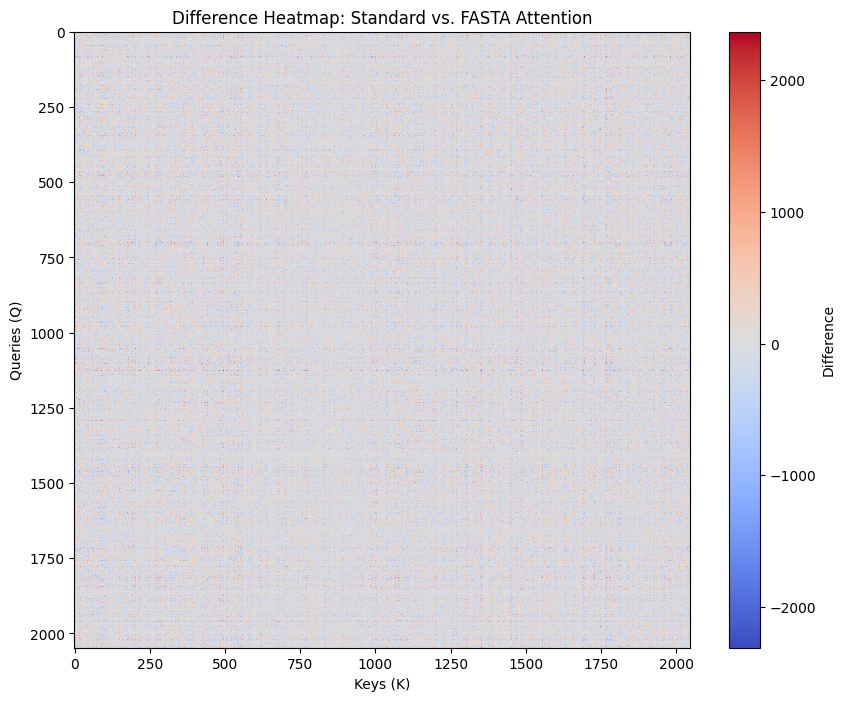

In [194]:
difference = (standard_outputs[0] - fasta_outputs[0])
# Create the heatmap for the first head
plt.figure(figsize=(10, 8))
plt.imshow(difference.squeeze(), cmap='coolwarm', interpolation='nearest')
plt.colorbar(label="Difference")
plt.title("Difference Heatmap: Standard vs. FASTA Attention")
plt.xlabel("Keys (K)")
plt.ylabel("Queries (Q)")
plt.show()

In [195]:
matrix = standard_outputs[0] / fasta_outputs[0]  # The ratio matrix

# Get the number of grids in each dimension
num_grids_x = matrix.shape[1] // block_size
num_grids_y = matrix.shape[0] // block_size

# Initialize variables to track max ratio and its grid position
max_ratio = -np.inf
max_grid = (0, 0)

# Iterate over grids
for i in range(num_grids_y):
    for j in range(num_grids_x):
        # Extract the current grid
        grid = matrix[i * block_size:(i + 1) * block_size, j * block_size:(j + 1) * block_size]
        
        # Compute the maximum ratio in the grid
        grid_max = np.max(grid)
        
        
        # Update max_ratio and max_grid if this grid has a higher max
        if grid_max > max_ratio:
            max_ratio = grid_max
            max_grid = (i, j)

# Output the result
print(f"Maximum ratio is {max_ratio} in grid (row, col): {max_grid}")

Maximum ratio is 33113.671875 in grid (row, col): (17, 1)


In [196]:
fasta_outputs[0]

array([[ 140.95934 ,  187.70464 ,   37.239906, ...,  328.34598 ,
        -303.2253  , -259.17737 ],
       [  23.23098 ,  113.06631 ,  328.6319  , ...,   89.88784 ,
         -91.04808 ,  200.29668 ],
       [-325.90497 ,   70.91901 , -148.46844 , ...,  -26.738686,
          34.493336, -325.34253 ],
       ...,
       [-412.7987  ,  102.62514 ,  -26.984077, ..., -357.88254 ,
         292.90182 , -156.12032 ],
       [-190.648   ,  249.13423 ,  345.80344 , ...,   49.541885,
          72.79786 ,  131.67494 ],
       [ 291.71213 ,   44.62805 ,  340.2364  , ...,  698.5998  ,
         231.26825 ,  425.0999  ]], dtype=float32)

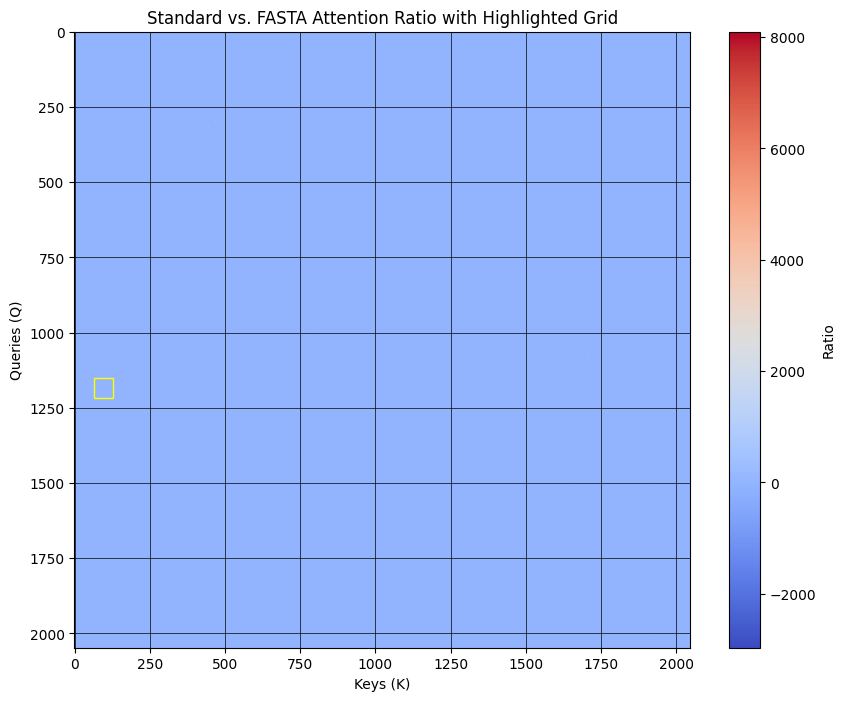

In [78]:
# Highlight the grid
plt.figure(figsize=(10, 8))
plt.imshow(standard_outputs[0] / fasta_outputs[0], cmap='coolwarm', interpolation='nearest')
plt.colorbar(label="Ratio")
plt.title("Standard vs. FASTA Attention Ratio with Highlighted Grid")
plt.xlabel("Keys (K)")
plt.ylabel("Queries (Q)")

# Add grid lines
plt.grid(True, which='both', color='black', linestyle='-', linewidth=0.5)

# Highlight the grid
rect_x = max_grid[1] * block_size
rect_y = max_grid[0] * block_size
rect = plt.Rectangle((rect_x, rect_y), block_size, block_size, edgecolor='yellow', facecolor='none', lw=1)
plt.gca().add_patch(rect)

plt.show()

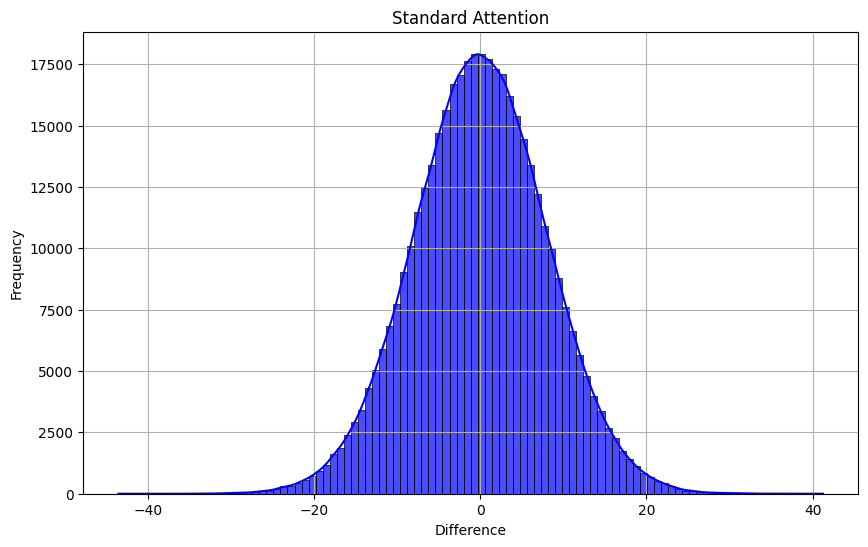

In [79]:
# Create the distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(standard_outputs[0].flatten()[::10], bins=100, kde=True, color='blue', alpha=0.7)
plt.title("Standard Attention")
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


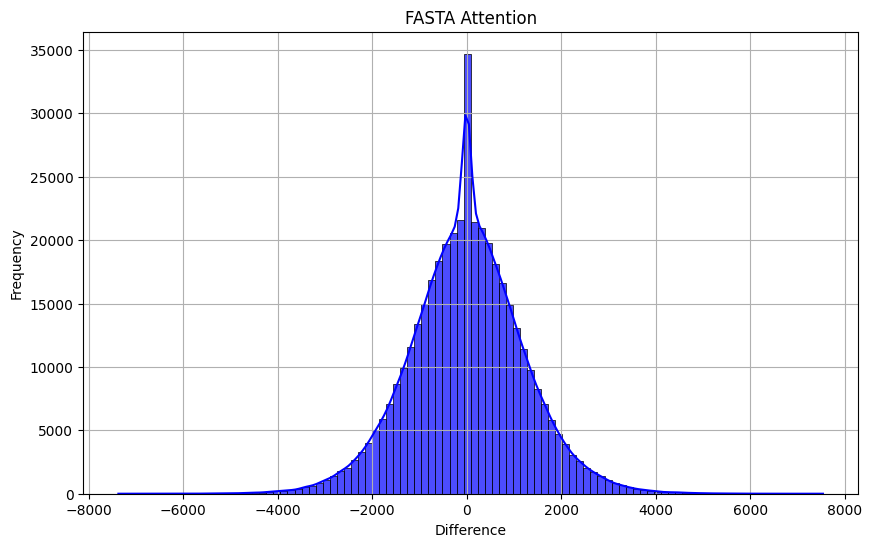

In [80]:
plt.figure(figsize=(10, 6))
sns.histplot(fasta_outputs[0].flatten()[::10], bins=100, kde=True, color='blue', alpha=0.7)
plt.title("FASTA Attention")
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

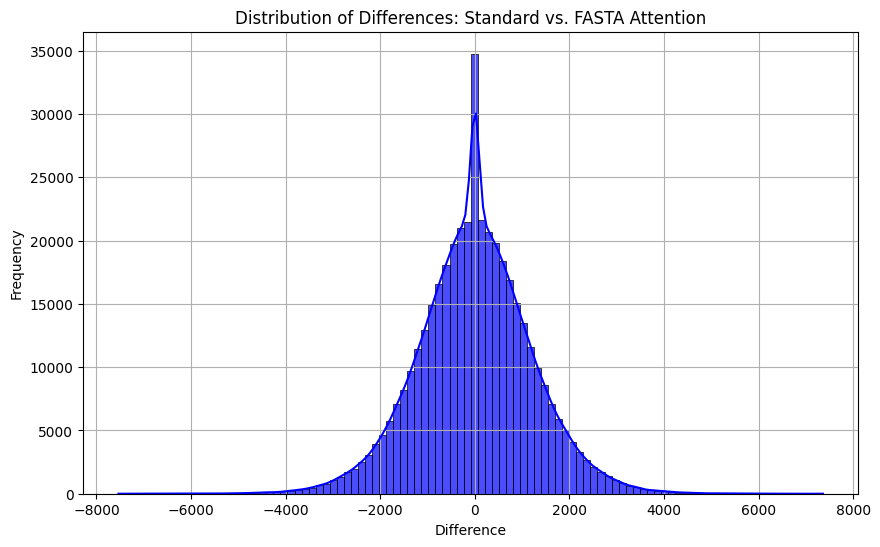

In [81]:
subsampled_difference = difference.flatten()[::10]  # Take every 10th value

# Create the distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(subsampled_difference, bins=100, kde=True, color='blue', alpha=0.7)
plt.title("Distribution of Differences: Standard vs. FASTA Attention")
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

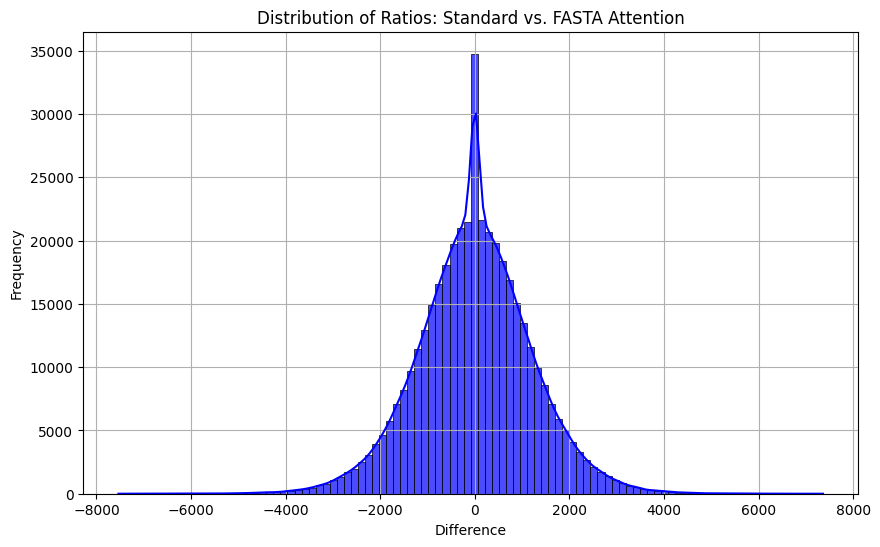

In [82]:
subsampled_ratio = (standard_outputs[0] / fasta_outputs[0]).flatten()[::10]  # Take every 10th value

# Create the distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(subsampled_difference, bins=100, kde=True, color='blue', alpha=0.7)
plt.title("Distribution of Ratios: Standard vs. FASTA Attention")
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [83]:
row_block_idx,col_block_idx = max_grid

# Compute Q indices
q_start = row_block_idx * block_size
q_end = (row_block_idx + 1) * block_size - 1

# Compute K indices
k_start = col_block_idx * block_size
k_end = (col_block_idx + 1) * block_size - 1

print(f"Q indices for block (row=6): {q_start} to {q_end}")
print(f"K indices for block (col=4): {k_start} to {k_end}")

Q indices for block (row=6): 1152 to 1215
K indices for block (col=4): 64 to 127


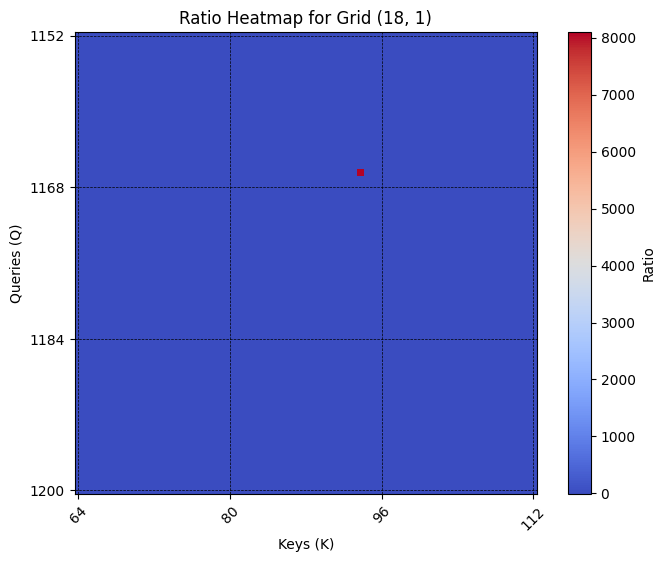

In [84]:
# Compute indices for the highlighted grid
q_start = max_grid[0] * block_size
q_end = (max_grid[0] + 1) * block_size
k_start = max_grid[1] * block_size
k_end = (max_grid[1] + 1) * block_size

# Extract the submatrix for the highlighted grid
highlighted_block = (standard_outputs[0] / fasta_outputs[0])[q_start:q_end, k_start:k_end]

# Generate x and y tick labels for indices
q_indices = np.arange(q_start, q_end, block_size // 4)  # Adjust granularity as needed
k_indices = np.arange(k_start, k_end, block_size // 4)

# Plot the heatmap for the highlighted block
plt.figure(figsize=(8, 6))
im = plt.imshow(highlighted_block, cmap='coolwarm', interpolation='nearest')
plt.colorbar(im, label="Ratio")
plt.title(f"Ratio Heatmap for Grid ({max_grid[0]}, {max_grid[1]})")
plt.xlabel("Keys (K)")
plt.ylabel("Queries (Q)")

# Set custom ticks for better index clarity
plt.xticks(ticks=np.linspace(0, block_size - 1, len(k_indices)), labels=k_indices, rotation=45)
plt.yticks(ticks=np.linspace(0, block_size - 1, len(q_indices)), labels=q_indices)

# Add grid lines for each block cell
plt.grid(True, which='both', linestyle='--', color='black', linewidth=0.5)

plt.show()